MNIST Digit Recognition with Deep Learning - Malik Endsley and Daniel Park <br/> Requires: Pydot

Our Dataset is Digit Recognition data. The Dataset contains test and training data of tens of thousands of images of numbers. It is from the MNIST library, famously used as a “hello world” of ML.

The information included in the dataset is succinct but complete. Each row represents a 28x28 image (784 pixels). There are 42,000 training images and 28,000 testing images.

Let's take a look at the data: <br/><br/><br/>

In [1]:
#all the imports have been retroactively moved to the 
#top so they're easily seen
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import to_categorical
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model
from keras.utils.vis_utils import plot_model

trainingDigits = pd.read_csv("data/train.csv")
testingDigits = pd.read_csv("data/test.csv")
trainingDigits.head()

Using TensorFlow backend.


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
testingDigits.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our data looks *very* strange, but the Kaggle page has some insight: <br/><br/> It appears data is encoded to where each pixel gets its own column and they are arranged left to right top to bottom. For reference: <br/> 000 001 002 003 ... 027 <br/> 028 030 031 032 ... 055 <br/> and et cetera. In other words, “x = i * 28 + j” (From the page explaining the decomposition of a pixel x.) <br/><br/>
	Each pixel has a lightness/darkness value ranging from 0 to 255, inclusive, which, when put together creates a grayscale image of a digit. The dataset does not contain any actual images of the data which means to view them we will write a parser. Some sample images look like this:


![title](img/MnistExamples.png)

Let's try and gain what we can from our data before we start working. We should find the proportions of the different numbers, as well as attempt to parse some individual columns. Matplotlib and Seaborn can help with those.

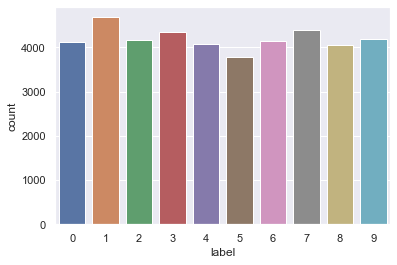

In [3]:
%matplotlib inline

sns.set(style="darkgrid")
proportionsAx = sns.countplot(x="label", data=trainingDigits)

Looks like all the numbers are represented pretty equally. There are a lot of 1s, though, and not quite as many 5s. Later, when we get predictions, we will see if more training data of a particular number improves that number's recognition. <br/> <br/> Let's get our data prepped.  <br/> <br/> 

In [4]:
X_train = trainingDigits.drop(labels = ["label"], axis=1)
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y_train = trainingDigits["label"]
y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

We can also double-check for missing data here.

In [6]:
print("Presence of missing data on inputs: " + str(X_train.isnull().values.any()) + "\nPresence of missing data on targets: " + str(y_train.isnull().values.any()))

Presence of missing data on inputs: False
Presence of missing data on targets: False


Then we will use matplotlib and some data manipulation to convert each row into a list of 28x28 matrices of pixel data (much more easily read). 

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
X_train.shape

(42000, 28, 28, 1)

Perfect. These newly created arrays are actually natively compatible with imshow offered by matplotlib. Using some sublots and a bit of iteration, we can regenerate a portion of the data as images to see exactly what we're working with. <br/> <br/>

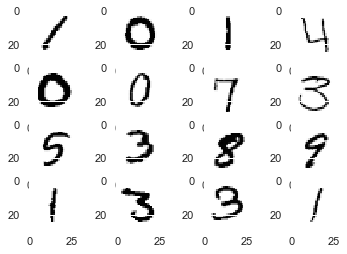

In [8]:
plt.rcParams["axes.grid"] #remove gridlines
fig, ax = plt.subplots(nrows=4, ncols=4)
index = 0
for row in ax:
    for col in row:
        col.imshow(X_train[index][:,:,0], cmap="Greys")
        index += 1

Notice the numbers (generated left to right top to bottom) match the "label" portion of the data below. This means we are on track.

In [9]:
y_train[:16]

0     1
1     0
2     1
3     4
4     0
5     0
6     7
7     3
8     5
9     3
10    8
11    9
12    1
13    3
14    3
15    1
Name: label, dtype: int64

As it stands, the target numbers are stored as 0-9, but this is technically categorical data. To make the data more readable, we use a process called one hot encoding, which transforms the categories (of which there are 10) into a 1x10 matrix where each target has a single 1 in it corresponding to which number it is. Encoding the number 0 looks like this:  <br/> <br/> [1,0,0,0,0,0,0,0,0,0]  <br/> <br/> The number 1 looks like: <br/> <br/> [0,1,0,0,0,0,0,0,0,0] <br/> <br/> And so on for each piece of data in the "label" column. <br/> <br/> The reason we do this isn't as obvious here, but it's more obvious when you use text based categories. If a sample target was classifying cars, and Honda Civic was 1, Mini Cooper was 2, and a Punchbuggy was 3, the network may incorrectly build the idea that a Civic is closer to a Cooper than a Punchbuggy. One hot encoding the data ensures that the related nature of the data is preserved, but not the numerical aspects. <br/> <br/> Below the data is encoded. Keras is a very powerful library for deep learning which runs on top of TensorFlow. to_categorical() is a utility function that automatically encodes the data provided a target dataset and the amount of categories.

In [10]:
y_train = to_categorical(y_train, num_classes = 10)

In [11]:
print(y_train[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


We'll also need to set up our testing data. This is done with a standard train-test split (the test.csv file doesn't actually have any answers in it). First we'll check the data looks right, then we'll split it 80/20 training/testing.

In [12]:
print(X_train[0][:,:,0])
print(y_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 188 255  94   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 191 250 253  93   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  123 248 253 167  10   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  80
  247 253 208  13   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

Looks good. Splitting: <br/> <br/>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=5292002)

In [14]:
print(str(X_train[0][:,:,0]) + "\n")
print(str(y_train[0]) + "\n")
print(str(X_test[0][:,:,0]) + "\n")
print(str(y_test[0]) + "\n")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  69 153 238 217
   40   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  15 166 254 244 176 238
   87   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  41 225 254 180  5

With the input data reshaped and viewed, the target data encoded, and the data split up properly, the process of building and training the CNN can begin. <br/> <br/>

In [15]:
model = Sequential()

In [16]:
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D( 64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = .75))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = .5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


We begin by defining a network called model. This is a sequential model, which is a beginner friendly building-block style model. Layers are added input to output using .add(). <br/><br/> Conv2D are convolutional layers, defined by the amount of filters they have, their kernel size, activation function, and initially, input shape. <br/> **Filters** refers to "slots" for patterns. <br/> **Kernel size** refers to how large the convolvers are. In this case they're very small because our images are only 28x28. <br/> **Activation function** refers to how the neurons in the network are excited. <br/> **Input shape** (only at the beginning) refers to how the input data is shaped. In this case it's 28x28x1 because it's grayscale.<br/><br/>MaxPooling2D is a layer that abstracts the layer before it, assisting with avoiding overfitting, generalization of the information, and simplifies the network slightly. It also takes a size which affects how "downsampled" the data becomes.<br/><br/>Dropout is a layer where portions of the network are shut off for each iteration, preventing the network from overfitting and promoting new pathways. The rate refers to how much of the network remains operational. <br/><br/> Flatten simply converts higher dimensional data into lower dimensional data to approach the number of outputs.<br/><br/> Dense layers are the "famous" fully interconnected layers, with one of them being dropped out 50% each time. The final Dense layer output width is 10 for 10 classes. <br/><br/><br/>
We then compile the model, which basically sets it up.

In [17]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['acc', 'mse'])

Compiling the network finalizes it by giving it a loss function, and an optimization algorithm. The loss function determines how to score it's decisions, and the optimizer determines how it will teach itself. For now we choose some general ones that work for categorical classification. <br/><br/><br/>Next we start running our model!<br/>Only run this if something changes. Otherwise, load the pre-trained one with the cell below it.

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=1024,
          epochs=2,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 33600 samples, validate on 8400 samples
Epoch 1/2


In [18]:
model = load_model('model1.h5')

Instructions for updating:
Use tf.cast instead.


That's some pretty good accuracy. Let's see where we went wrong and where we can improve. We'll save the model in it's current state so we can compare it later.

In [38]:
model.save('model1.h5')

We should also ensure our model looks right. Directly below we'll pull up a summary of our model, then below that generate a graph of the layers.

In [19]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [27]:
plot_model(model, to_file='img/model_plot.png', show_shapes=True, show_layer_names=True)


![title](img/model_plot.png)

The first layer accepts the 28x28 matrix, then it is dropped down to 26x26x32 (26x26 is a side effect of pooling, and 32 indicates the filters) and once more to 24x24x64 (another dimensional reduction for pooling and 64 filters). Then it is pooled again, then dropped out, then flattened into a very long vector, then run through two densely connected layers which eventually output a vector classification. That sounds exactly like what we were hoping to do. <br/> <br/> Fitting a model exposes some statistics about it which are available for graphing. Let's look at a few characteristics of the training process to evaluate how the network did.

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='center right')
plt.show()

NameError: name 'history' is not defined

In [30]:
predictions = model.predict_classes(X_test, batch_size=None, verbose=1)


8400/8400 [==============================] - 4s 513us/step


In [31]:
print(predictions)

[3 7 6 ... 0 8 7]
